<a href="https://colab.research.google.com/github/Kiran-01/Product-Image-Generation/blob/main/CGAN_with_Shoe_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle


In [2]:
! cp kaggle.json ~/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
! chmod 600 ~/.kaggle/kaggle.json


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
# ! kaggle datasets download noobyogi0100/shoe-dataset
# ! unzip shoe-dataset.zip

In [1]:
cd /content/drive/MyDrive/Shoe Dataset

/content/drive/MyDrive/Shoe Dataset


In [2]:
!pip install torchsummary
!pip install gdown

In [2]:
import torch
import numpy as np
from PIL import Image
from IPython.display import display
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
# from torchsummary import summary
import matplotlib.pyplot as plt
import datetime
import os

In [3]:
torch.manual_seed(17)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

In [4]:
directory = '/content/drive/MyDrive/Shoe Dataset/shoeTypeClassifierDataset/training'
n_classes = 6

train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
train_dataset = datasets.ImageFolder(root=directory, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [5]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(64, 64))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=8).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


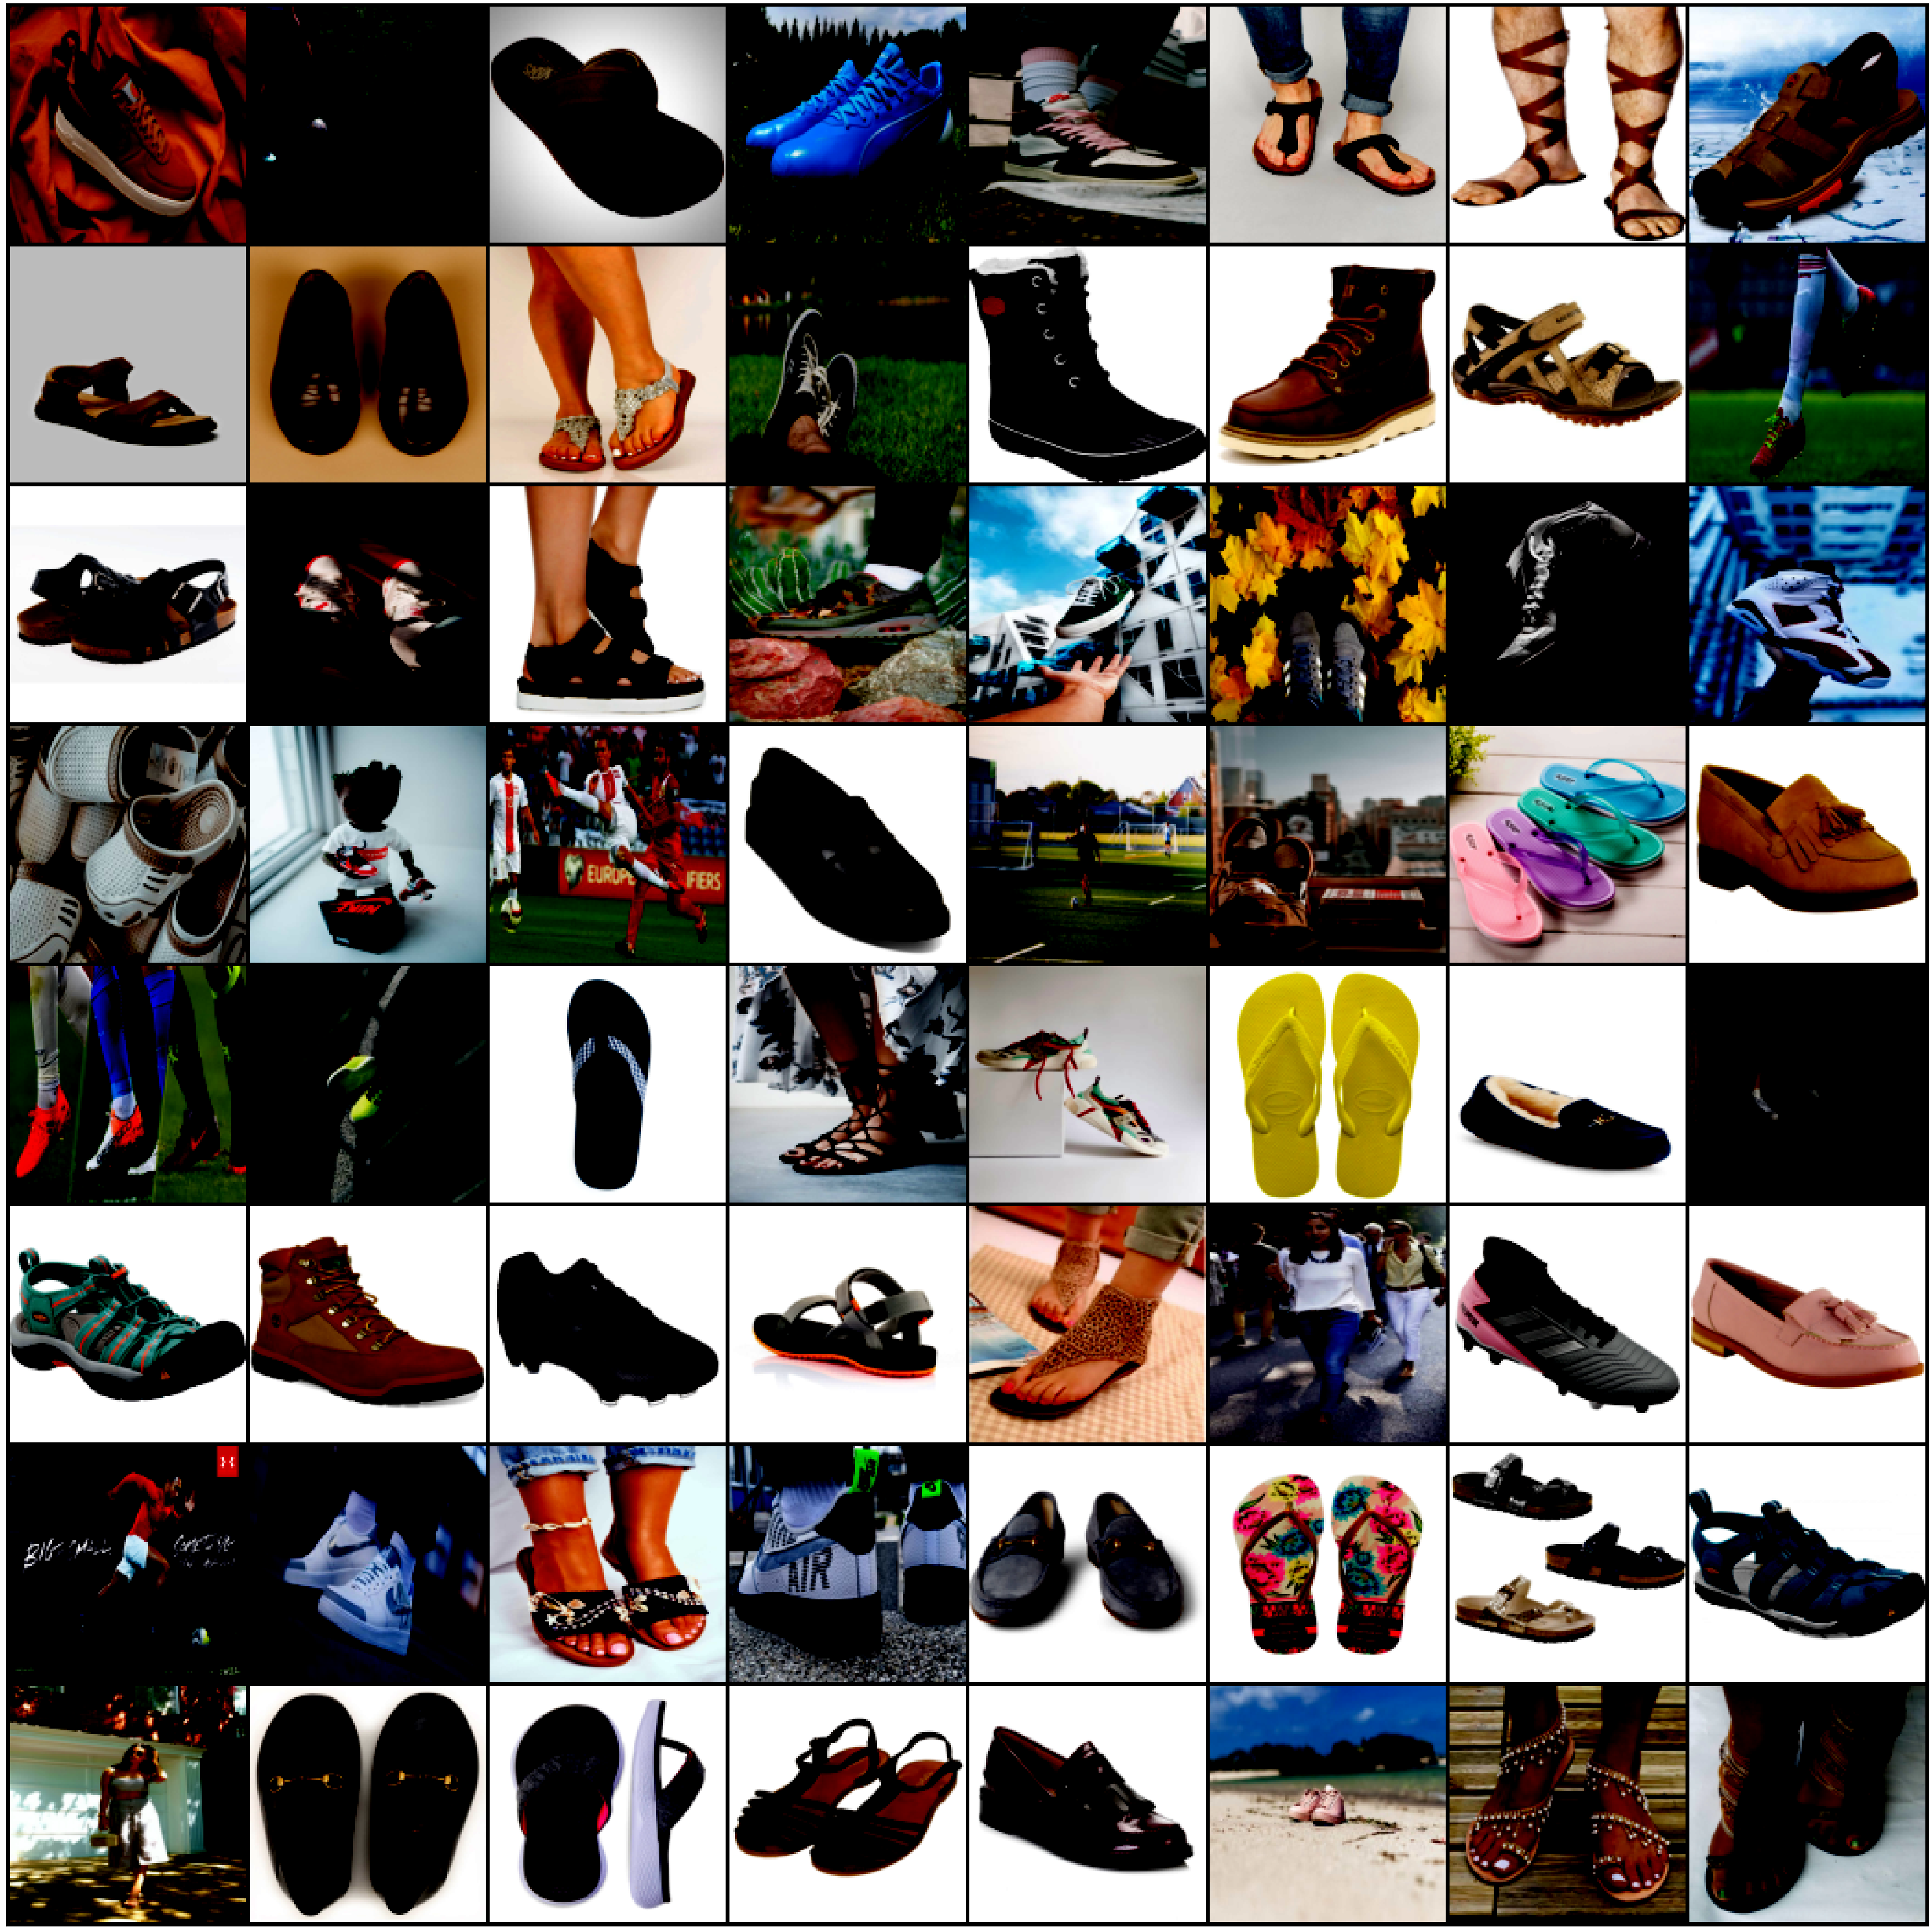

In [6]:
show_batch(train_loader)

In [7]:
image_shape = (3, 128, 128)
image_dim = int(np.prod(image_shape))
latent_dim = 100
embedding_dim = 100

In [8]:
#definemodel
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))
        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2,   momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

In [10]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(6, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_si

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*128*128))
             
        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid())

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

In [12]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(6, 100)
    (1): Linear(in_features=100, out_features=49152, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)


In [13]:
adversarial_loss = nn.BCELoss()

def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    return gen_loss

def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [14]:
learning_rate = 0.0002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

checkpoint.pt exist.. loading last checkpoint
Epoch: [520/540]: D_loss: 0.032, G_loss: 6.329
Saving sample output Sample_epoch_520.png


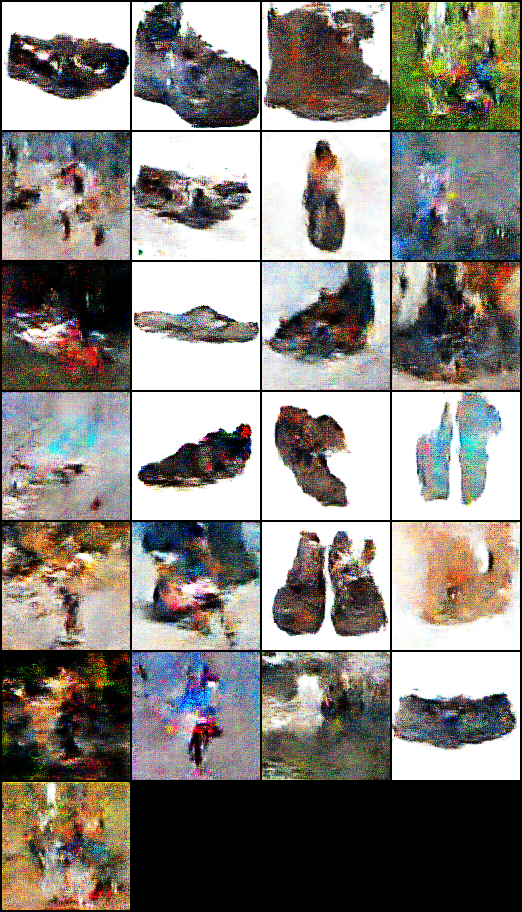

Saving model training check point
Epoch: [521/540]: D_loss: 2.193, G_loss: 6.751
Epoch: [522/540]: D_loss: 0.224, G_loss: 6.668
Epoch: [523/540]: D_loss: 0.101, G_loss: 6.074
Epoch: [524/540]: D_loss: 0.075, G_loss: 6.361
Epoch: [525/540]: D_loss: 0.055, G_loss: 6.264
Epoch: [526/540]: D_loss: 0.046, G_loss: 6.346
Epoch: [527/540]: D_loss: 0.042, G_loss: 6.320
Epoch: [528/540]: D_loss: 0.035, G_loss: 6.267
Epoch: [529/540]: D_loss: 0.039, G_loss: 6.357
Epoch: [530/540]: D_loss: 0.048, G_loss: 6.639
Saving sample output Sample_epoch_530.png


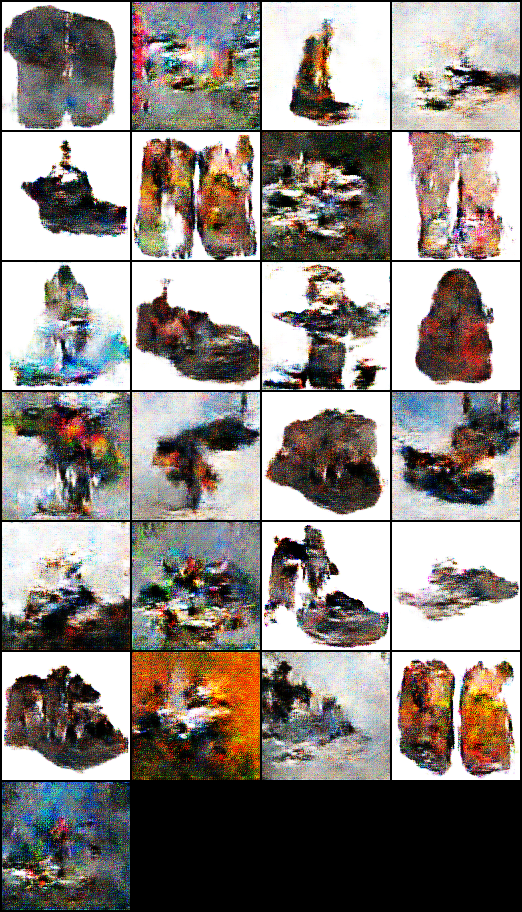

Saving model training check point
Epoch: [531/540]: D_loss: 0.032, G_loss: 6.463
Epoch: [532/540]: D_loss: 0.034, G_loss: 6.495
Epoch: [533/540]: D_loss: 0.029, G_loss: 6.500
Epoch: [534/540]: D_loss: 0.030, G_loss: 6.724
Epoch: [535/540]: D_loss: 0.031, G_loss: 6.849
Epoch: [536/540]: D_loss: 0.030, G_loss: 6.734
Epoch: [537/540]: D_loss: 0.031, G_loss: 6.922
Epoch: [538/540]: D_loss: 0.034, G_loss: 7.033
Epoch: [539/540]: D_loss: 0.028, G_loss: 6.892
Epoch: [540/540]: D_loss: 0.023, G_loss: 7.070
Saving sample output Sample_epoch_540.png


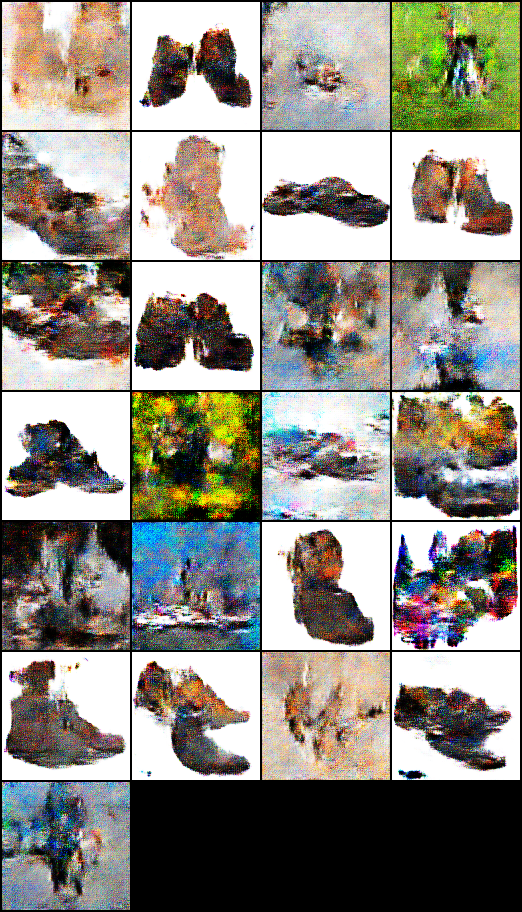

Saving model training check point


In [15]:
num_epochs = 540
start_epoch =532
checkpoint_file = "/content/drive/MyDrive/Shoe Dataset/checkpoint.pt"
# checkpoint_file = '/content/drive/MyDrive/Shoe Dataset/checkpoint.pt'

if os.path.isfile(checkpoint_file):
    print("checkpoint.pt exist.. loading last checkpoint")
    checkpoint = torch.load(checkpoint_file)
    generator.load_state_dict(checkpoint['g_state_dict'])
    discriminator.load_state_dict(checkpoint['d_state_dict'])
    G_optimizer.load_state_dict(checkpoint['g_optimizer'])
    D_optimizer.load_state_dict(checkpoint['d_optimizer'])
    start_epoch = checkpoint['epoch']

D_loss_plot, G_loss_plot = [], []
for epoch in range(start_epoch, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()

        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
      
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
               
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)

        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()

    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))

    #saving outputs every Nth time
    if (epoch) % 10 == 0:
        checkpoint = {
            'epoch': epoch,
            'd_state_dict': discriminator.state_dict(),
            'g_state_dict': generator.state_dict(),
            'g_optimizer': G_optimizer.state_dict(),
            'd_optimizer': D_optimizer.state_dict()
        }
                
        filename = 'Sample_epoch_%d'% epoch + '.png'
        print("Saving sample output {}".format(filename))
        save_image(generated_image.data[:50], filename, nrow=4, normalize=True)
        display(Image.open(filename))
        
        torch.save(generator.state_dict(), 'generator_epoch_%d.pth' % (epoch))
        torch.save(discriminator.state_dict(), 'discriminator_epoch_%d.pth' % (epoch))

        print ("Saving model training check point")
        torch.save(checkpoint, checkpoint_file)

In [16]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [17]:
# evaluate the trained model
from numpy.random import randn

generator = Generator().to(device)
generator.load_state_dict(torch.load('generator_epoch_530.pth'), strict=False)
generator.eval()

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(6, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_si

In [ ]:
# # labels
# 0 = boots
# 1 = flip_flops
# 2 = loafers
# 3 = sandals
# 4 = sneakers
# 5 = soccer_shoes

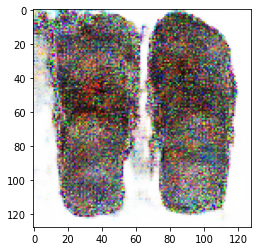

In [26]:
label = 1
labels = torch.ones(1) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()

noise_vector = torch.randn(1, latent_dim, device=device)  
noise_vector = noise_vector.to(device)
generated_image = generator((noise_vector, labels))
generated_image = generated_image.permute(0,2,3,1)
generated_image = generated_image.detach().cpu() * 255
generated_image = np.array(generated_image) 
plt.imshow(generated_image[0].astype(np.uint8))

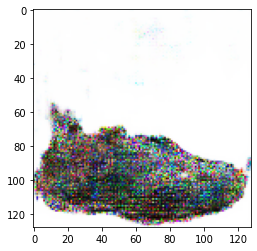

In [31]:
label = 0
labels = torch.ones(1) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()

noise_vector = torch.randn(1, latent_dim, device=device)  
noise_vector = noise_vector.to(device)
generated_image = generator((noise_vector, labels))
generated_image = generated_image.permute(0,2,3,1)
generated_image = generated_image.detach().cpu() * 255
generated_image = np.array(generated_image) 
plt.imshow(generated_image[0].astype(np.uint8))

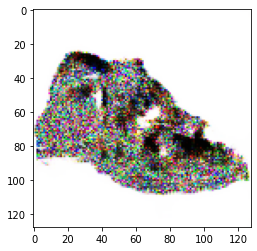

In [62]:
label = 3
labels = torch.ones(1) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()

noise_vector = torch.randn(1, latent_dim, device=device)  
noise_vector = noise_vector.to(device)
generated_image = generator((noise_vector, labels))
generated_image = generated_image.permute(0,2,3,1)
generated_image = generated_image.detach().cpu() * 255
generated_image = np.array(generated_image) 
plt.imshow(generated_image[0].astype(np.uint8))

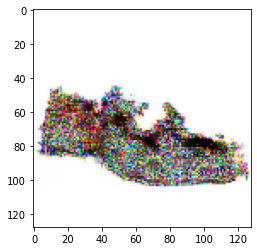

In [63]:
label = 3
labels = torch.ones(1) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()

noise_vector = torch.randn(1, latent_dim, device=device)  
noise_vector = noise_vector.to(device)
generated_image = generator((noise_vector, labels))
generated_image = generated_image.permute(0,2,3,1)
generated_image = generated_image.detach().cpu() * 255
generated_image = np.array(generated_image) 
plt.imshow(generated_image[0].astype(np.uint8))

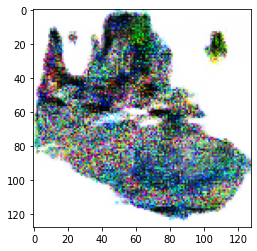

In [52]:
label = 5
labels = torch.ones(1) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()

noise_vector = torch.randn(1, latent_dim, device=device)  
noise_vector = noise_vector.to(device)
generated_image = generator((noise_vector, labels))
generated_image = generated_image.permute(0,2,3,1)
generated_image = generated_image.detach().cpu() * 255
generated_image = np.array(generated_image) 
plt.imshow(generated_image[0].astype(np.uint8))

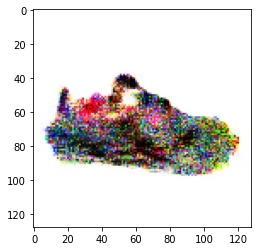

In [64]:
label = 5
labels = torch.ones(1) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()

noise_vector = torch.randn(1, latent_dim, device=device)  
noise_vector = noise_vector.to(device)
generated_image = generator((noise_vector, labels))
generated_image = generated_image.permute(0,2,3,1)
generated_image = generated_image.detach().cpu() * 255
generated_image = np.array(generated_image) 
plt.imshow(generated_image[0].astype(np.uint8))

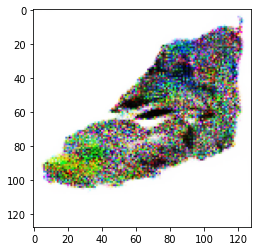

In [81]:
label = 5
labels = torch.ones(1) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()

noise_vector = torch.randn(1, latent_dim, device=device)  
noise_vector = noise_vector.to(device)
generated_image = generator((noise_vector, labels))
generated_image = generated_image.permute(0,2,3,1)
generated_image = generated_image.detach().cpu() * 255
generated_image = np.array(generated_image) 
plt.imshow(generated_image[0].astype(np.uint8))

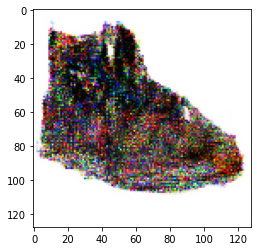

In [113]:
label = 0
labels = torch.ones(1) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()

noise_vector = torch.randn(1, latent_dim, device=device)  
noise_vector = noise_vector.to(device)
generated_image = generator((noise_vector, labels))
generated_image = generated_image.permute(0,2,3,1)
generated_image = generated_image.detach().cpu() * 255
generated_image = np.array(generated_image) 
plt.imshow(generated_image[0].astype(np.uint8))